<a href="https://colab.research.google.com/github/nepslor/teaching/blob/main/TimeSeriesForecasting/decision_under_uncertainty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single stage decisions
## Demand side management through ripple control


In [80]:
import pandas as pd
import numpy as np
data = pd.read_pickle('data/energy_signature_data.zip')
data.head()

,GHI,T,battery_p,battery_q,heat_pump_p,heat_pump_q,main_p,main_q,pv_p,pv_q,relay
2015-10-01 00:00:00+00:00,-2.781167,9.500000,0.037667,0.170167,0.0,0.0,0.448167,0.520833,0.003,0.075833,NaN
2015-10-01 00:01:00+00:00,-2.803333,9.496667,0.038000,0.169333,0.0,0.0,0.476333,0.520500,0.003,0.075500,NaN
2015-10-01 00:02:00+00:00,-2.856000,9.400000,0.038000,0.170000,0.0,0.0,0.464833,0.521500,0.003,0.076000,NaN
2015-10-01 00:03:00+00:00,-2.886833,9.400000,0.038000,0.170000,0.0,0.0,0.443000,0.517667,0.003,0.076000,NaN
2015-10-01 00:04:00+00:00,-2.911667,9.400000,0.038000,0.170000,0.0,0.0,0.441833,0.516833,0.003,0.076000,NaN


[(1.0, 7.0), (1.0, 7.0), (1.0, 7.0)]

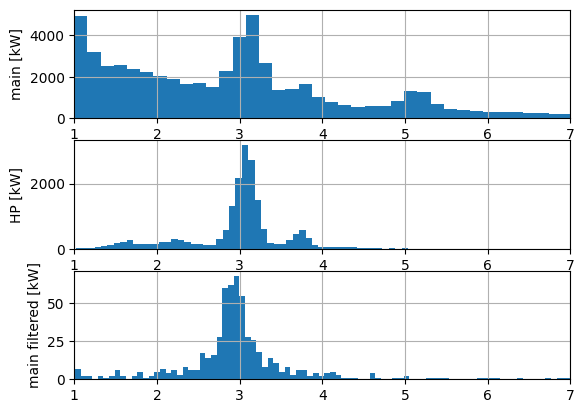

In [82]:
import matplotlib.pyplot as plt
data['heat_pump_p'].iloc[:-1], _, _ = merge_ramps(data['heat_pump_p'])
data['main_p'].iloc[:-1], _, _ = merge_ramps(data['main_p'])
fig, ax= plt.subplots(3, 1)
n_bins = 200
filt = data['main_p']>1
data['main_p'].loc[filt].\
    hist(bins=n_bins*2, ax=ax[0])

data['heat_pump_p'].loc[filt & data['heat_pump_p']>0].\
    hist(bins=n_bins, ax=ax[1])

data['main_p'].loc[np.roll(data[['relay']].diff().values==1, 1)].loc[filt].\
    hist(bins=n_bins, ax=ax[2])
[a.set_ylabel(t) for a, t in zip(ax, ['main [kW]', 'HP [kW]', 'main filtered [kW]'])]
[a.set_xlim([1, 7]) for a in ax.ravel()]



In [56]:

def merge_ramps(x, x_high=0.5, x_low=0.1, x_filt_1=None, x_filt_2=None):
    """
    Merge first order derivative such as jumps occurring in between two sampling times are LIKELY joined together.
    :param x: np.ndarray of the signal
    :param x_high: threshold for identifying interesting derivatives
    :param x_low: threshold for merging derivatives
    :return:
    """
    x_diff = np.diff(x.ravel())
    if x_filt_1 is None:
        x_filt_1 = np.where(x_diff > x_high)[0]
    for f in x_filt_1:
        if f >= len(x_diff) - 1:
            continue
        x_f = x_diff[f - 1:f + 2]
        # if np.any(x_f[[0, 2]] > x_low):
        x_diff[f + 1] = np.sum(x_f[x_f > x_low])
        x_diff[f] = 0

    if x_filt_2 is None:
        x_filt_2 = np.where(x_diff < -x_high)[0]
    for f in x_filt_2:
        if f >= len(x_diff) - 1:
            continue
        x_f = x_diff[f - 1:f + 2]
        # if np.any(x_f[[0, 2]] < -x_low):
        x_diff[f] = np.sum(x_f[x_f < -x_low])
        x_diff[f + 1] = 0

    # x_diff[np.abs(x_diff) <= x_high] = 0 #should be OK to do this!
    return x_diff, x_filt_1, x_filt_2